<a href="https://colab.research.google.com/github/318281029SBH/Escuela/blob/main/GWeatherLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_classif
from sklearn.metrics import r2_score

In [46]:
from sklearn.metrics import r2_score

# Exploratory Analysis

In [4]:
df=pd.read_csv('/content/drive/MyDrive/dataSet/DWD.csv', sep=',', index_col=0 )

In [5]:
dwd=df.drop(['DWD_ID', 'STATION_NAME', 'FEDERAL_STATE', 'PERIOD'], axis=1)

In [ ]:
dwd.loc[lambda dwd: dwd.isnull().any(axis=1)].shape

(395, 17)

In [6]:
miss=dwd.describe().T[['count']]/len(dwd) #establece la proporción de registros por columna respecto al total
areleft=miss.loc[miss['count']>.7]
dwd=dwd[[v for v in areleft.index]] # se eliminan las columnas con más del 70% de valores ausentes

##Data Visualization

In [ ]:
dwd.hist(figsize=(15,15))

# Imputar, strategy:Median

In [7]:
im = SimpleImputer(strategy='median')
im.fit(dwd)

SimpleImputer(strategy='median')

In [8]:
Xi = pd.DataFrame(im.transform(dwd),columns=dwd.columns) #imputa valores vacíos con mediana

In [9]:
Xi.describe()

,LAT,LON,ALTITUDE,RECORD_LENGTH,MEAN_ANNUAL_AIR_TEMP,MEAN_MONTHLY_MAX_TEMP,MEAN_MONTHLY_MIN_TEMP,MEAN_ANNUAL_WIND_SPEED,MEAN_CLOUD_COVER,MEAN_ANNUAL_RAINFALL,MAX_MONTHLY_WIND_SPEED,MAX_AIR_TEMP,MAX_RAINFALL,MIN_AIR_TEMP,MEAN_RANGE_AIR_TEMP
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,50.748483,10.119593,285.283806,80.073456,8.401503,12.656761,4.488815,2.121870,66.806344,786.166110,2.726210,31.840401,38.494157,-14.932888,8.168280
std,1.898860,2.054339,283.779402,36.821152,1.226497,1.492081,1.180793,0.694103,3.035888,231.319216,0.785635,2.007345,7.280079,2.570010,1.165744
min,47.398600,6.094100,1.000000,30.000000,2.500000,3.300000,0.300000,1.000000,56.000000,446.000000,1.000000,13.900000,25.000000,-25.400000,0.000000
25%,49.271750,8.477350,75.000000,54.000000,8.000000,12.100000,3.800000,2.000000,65.000000,642.000000,2.000000,31.100000,34.000000,-16.700000,7.600000
50%,50.639000,9.966200,224.000000,70.000000,8.500000,12.900000,4.600000,2.000000,67.000000,737.500000,3.000000,32.200000,36.000000,-14.900000,8.400000
75%,51.956800,11.702800,418.000000,103.000000,9.100000,13.500000,5.300000,2.000000,68.000000,854.000000,3.000000,33.100000,41.000000,-13.300000,8.900000
max,55.011000,14.950600,2964.000000,297.000000,11.000000,15.600000,7.300000,6.000000,79.000000,1995.000000,7.000000,35.400000,76.000000,-5.300000,11.100000


In [10]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xi[v],dwd[v].dropna()).statistic),dwd.columns),columns=['var','ks']).sort_values('ks',ascending=False) #prueba Kolmogorov-Smirnof para determinar si mantiene la distribución
ks

,var,ks
12,MAX_RAINFALL,0.011347
9,MEAN_ANNUAL_RAINFALL,0.010851
8,MEAN_CLOUD_COVER,0.008620
10,MAX_MONTHLY_WIND_SPEED,0.007777
7,MEAN_ANNUAL_WIND_SPEED,0.004154
6,MEAN_MONTHLY_MIN_TEMP,0.003255
11,MAX_AIR_TEMP,0.001650
13,MIN_AIR_TEMP,0.001650
5,MEAN_MONTHLY_MAX_TEMP,0.001600
4,MEAN_ANNUAL_AIR_TEMP,0.000815


In [11]:
out = ks[ks['ks']>0.1]['var'].tolist() #variables que deben salir
var = [v for v in Xi.columns if v not in out] # variables que deben permanecer
Xi.drop(out,axis=1,inplace=True)

# OutLayers

array([[<Axes: title={'center': 'RECORD_LENGTH'}>,
        <Axes: title={'center': 'MEAN_ANNUAL_AIR_TEMP'}>],
       [<Axes: title={'center': 'MEAN_MONTHLY_MAX_TEMP'}>,
        <Axes: title={'center': 'MEAN_MONTHLY_MIN_TEMP'}>]], dtype=object)

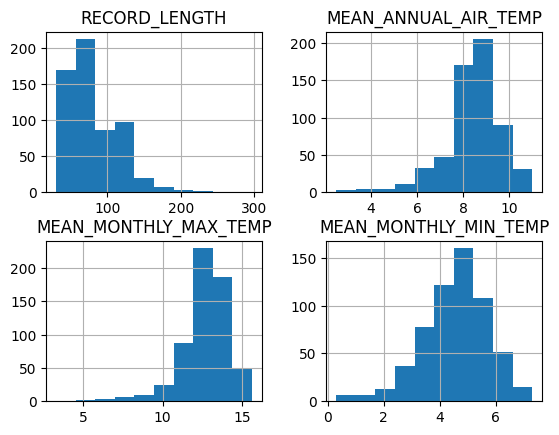

In [ ]:
Xi.hist(['RECORD_LENGTH', 'MEAN_ANNUAL_AIR_TEMP',
       'MEAN_MONTHLY_MAX_TEMP', 'MEAN_MONTHLY_MIN_TEMP'])

In [ ]:
Xi.describe().T[['50%','75%']].reset_index().values

array([['LAT', 50.639, 51.9568],
       ['LON', 9.9662, 11.7028],
       ['ALTITUDE', 224.0, 418.0],
       ['RECORD_LENGTH', 70.0, 103.0],
       ['MEAN_ANNUAL_AIR_TEMP', 8.5, 9.1],
       ['MEAN_MONTHLY_MAX_TEMP', 12.9, 13.5],
       ['MEAN_MONTHLY_MIN_TEMP', 4.6, 5.3],
       ['MEAN_ANNUAL_WIND_SPEED', 2.0, 2.0],
       ['MEAN_CLOUD_COVER', 67.0, 68.0],
       ['MEAN_ANNUAL_RAINFALL', 737.5, 854.0],
       ['MAX_MONTHLY_WIND_SPEED', 3.0, 3.0],
       ['MAX_AIR_TEMP', 32.2, 33.1],
       ['MAX_RAINFALL', 36.0, 41.0],
       ['MIN_AIR_TEMP', -14.9, -13.3],
       ['MEAN_RANGE_AIR_TEMP', 8.4, 8.9]], dtype=object)

In [12]:
for v,li,ls in Xi.describe(percentiles=[0.02,0.98]).T[['2%','98%']].reset_index().values: # v es la columna, li limite inferior, ls limite superior
    Xi[f'extreme_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int) # etiqueta con unos las observaciones que se consideran extremos y 0's las que no

In [13]:
Xi.filter(like="extreme", axis=1).sum() # cuenta los valores extremos por columna

,0
extreme_LAT,24
extreme_LON,24
extreme_ALTITUDE,24
extreme_RECORD_LENGTH,22
extreme_MEAN_ANNUAL_AIR_TEMP,22
extreme_MEAN_MONTHLY_MAX_TEMP,23
extreme_MEAN_MONTHLY_MIN_TEMP,20
extreme_MEAN_ANNUAL_WIND_SPEED,2
extreme_MEAN_CLOUD_COVER,15
extreme_MEAN_ANNUAL_RAINFALL,23


In [14]:
Xi['ex_'] = Xi.filter(like='extreme').max(axis=1) #etiqueta registros con un outlayer en al menos una columna
Xi=Xi.drop(Xi.filter(like='extreme_', axis=1).columns, axis=1) #elimina las columnas empleadas previamente (valor extremo por columna)

In [ ]:
Xi['ex_'].value_counts(normalize=True) # pérdida de observaciones 26%

,proportion
ex_,
0,0.732888
1,0.267112


In [15]:
Xi = Xi[Xi['ex_']==0].reset_index(drop=True).drop(Xi.filter(like='ex_'),axis=1)# se eliminan outlayers, se resetea el index y elimina columna auxiliar de extremos

array([[<Axes: title={'center': 'RECORD_LENGTH'}>,
        <Axes: title={'center': 'MEAN_ANNUAL_AIR_TEMP'}>],
       [<Axes: title={'center': 'MEAN_MONTHLY_MAX_TEMP'}>,
        <Axes: title={'center': 'MEAN_MONTHLY_MIN_TEMP'}>]], dtype=object)

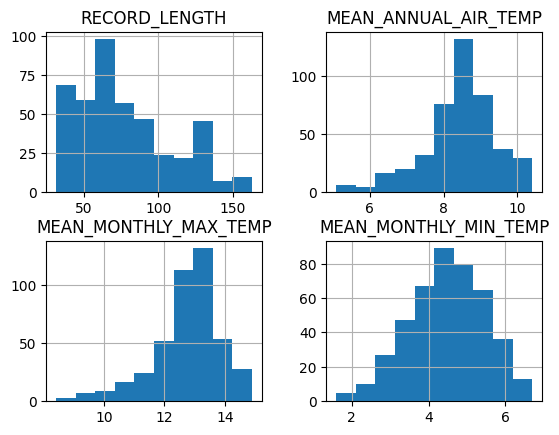

In [ ]:
Xi.hist(['RECORD_LENGTH', 'MEAN_ANNUAL_AIR_TEMP',
       'MEAN_MONTHLY_MAX_TEMP', 'MEAN_MONTHLY_MIN_TEMP'])

# Preparing training set and test set

In [16]:
#df = Xi.drop('MEAN_ANNUAL_RAINFALL', axis=1)
train_set = Xi.sample(frac=.7)
test_set = Xi.drop(train_set.index)


In [17]:
train_set.shape, test_set.shape

((307, 15), (132, 15))

# Model

In [18]:
corr = dwd.corr()
#corr

,LAT,LON,ALTITUDE,RECORD_LENGTH,MEAN_ANNUAL_AIR_TEMP,MEAN_MONTHLY_MAX_TEMP,MEAN_MONTHLY_MIN_TEMP,MEAN_ANNUAL_WIND_SPEED,MEAN_CLOUD_COVER,MEAN_ANNUAL_RAINFALL,MAX_MONTHLY_WIND_SPEED,MAX_AIR_TEMP,MAX_RAINFALL,MIN_AIR_TEMP,MEAN_RANGE_AIR_TEMP
LAT,1.000000,0.123679,-0.623111,0.032320,0.129788,-0.137148,0.329515,0.425055,0.146055,-0.439290,0.469797,-0.126387,-0.547341,0.370217,-0.498191
LON,0.123679,1.000000,0.097831,-0.018083,-0.324743,-0.246576,-0.337285,0.124347,-0.104029,-0.152795,0.117105,-0.020621,0.118275,-0.516428,0.031389
ALTITUDE,-0.623111,0.097831,1.000000,-0.018462,-0.783173,-0.605236,-0.757139,0.081405,0.097458,0.709002,0.064511,-0.576565,0.713742,-0.513694,-0.037802
RECORD_LENGTH,0.032320,-0.018083,-0.018462,1.000000,-0.002850,-0.005976,0.034633,0.097248,0.015981,-0.065195,0.080953,0.014113,-0.051789,0.058918,-0.048075
MEAN_ANNUAL_AIR_TEMP,0.129788,-0.324743,-0.783173,-0.002850,1.000000,0.887118,0.890633,-0.266979,-0.231833,-0.539133,-0.273076,0.745390,-0.517464,0.575752,0.202567
MEAN_MONTHLY_MAX_TEMP,-0.137148,-0.246576,-0.605236,-0.005976,0.887118,1.000000,0.646701,-0.487803,-0.264754,-0.439943,-0.484579,0.915993,-0.379389,0.275047,0.575387
MEAN_MONTHLY_MIN_TEMP,0.329515,-0.337285,-0.757139,0.034633,0.890633,0.646701,1.000000,0.038829,-0.178004,-0.445130,0.042769,0.458093,-0.466684,0.819568,-0.238723
MEAN_ANNUAL_WIND_SPEED,0.425055,0.124347,0.081405,0.097248,-0.266979,-0.487803,0.038829,1.000000,0.201159,0.011600,0.784203,-0.484582,-0.033289,0.207523,-0.655602
MEAN_CLOUD_COVER,0.146055,-0.104029,0.097458,0.015981,-0.231833,-0.264754,-0.178004,0.201159,1.000000,0.081362,0.176642,-0.225801,-0.005216,-0.028448,-0.203383
MEAN_ANNUAL_RAINFALL,-0.439290,-0.152795,0.709002,-0.065195,-0.539133,-0.439943,-0.445130,0.011600,0.081362,1.000000,0.017099,-0.509815,0.863788,-0.186723,-0.122783


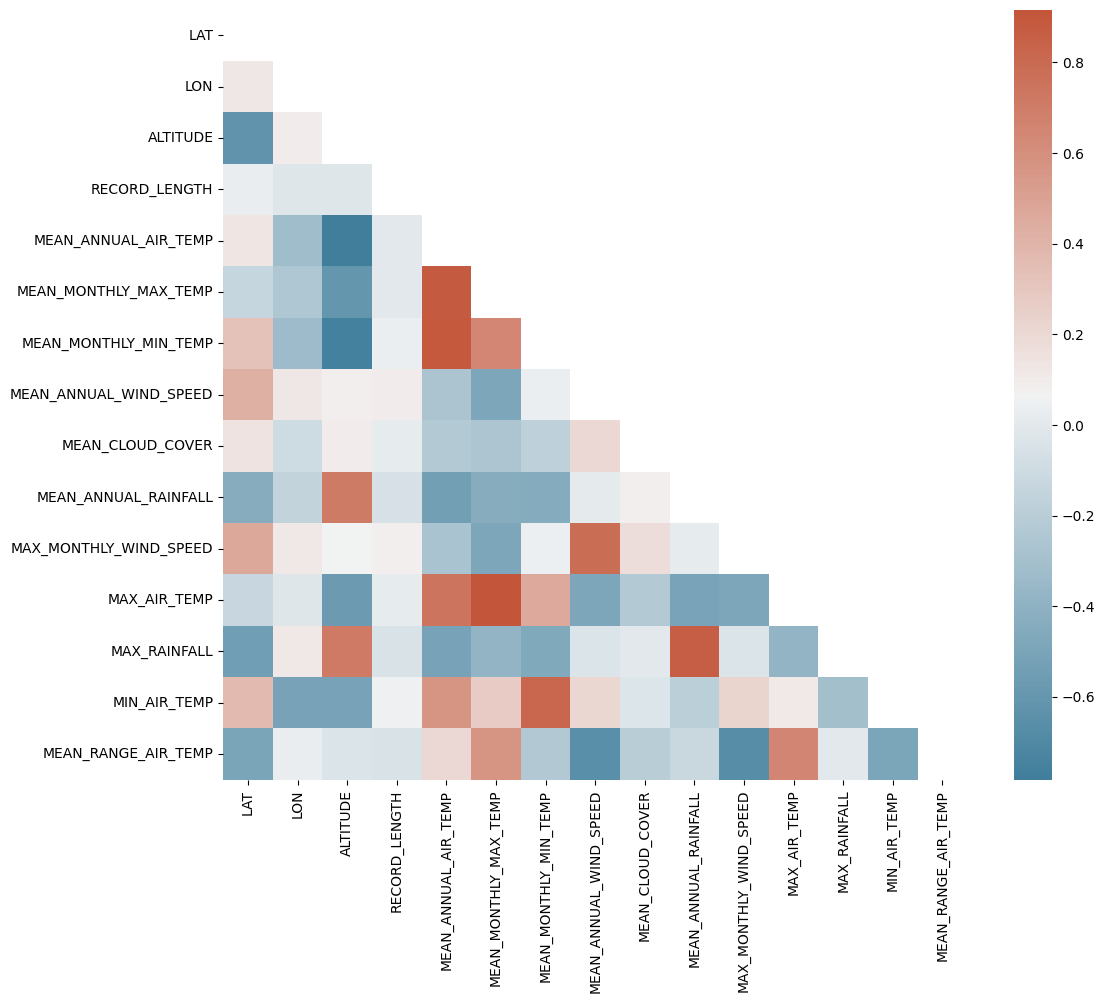

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=cmap)
plt.show()

In [ ]:
### Peores predictores
features=Xi.columns.to_list()
listmaxCorr = [np.corrcoef(Xi["MEAN_ANNUAL_RAINFALL"], Xi[x]) for x in corr.columns] # Use a list comprehension instead of map
#maxCorr=np.array(map(lambda x: np.corrcoef(Xi["ALTITUDE"], Xi[x]), corr.columns))
#maxCorr



In [44]:
#best features
corr.loc[corr.abs()['MEAN_ANNUAL_RAINFALL']>.5].filter(like='MEAN_ANNUAL_RAINFALL', axis=1).sort_values(by='MEAN_ANNUAL_RAINFALL', ascending=False)


,MEAN_ANNUAL_RAINFALL
MEAN_ANNUAL_RAINFALL,1.000000
MAX_RAINFALL,0.863788
ALTITUDE,0.709002
MAX_AIR_TEMP,-0.509815
MEAN_ANNUAL_AIR_TEMP,-0.539133


## Features Selection

Backward Selection

In [45]:
features=dwd.columns.to_list()

['LAT',
 'LON',
 'ALTITUDE',
 'RECORD_LENGTH',
 'MEAN_ANNUAL_AIR_TEMP',
 'MEAN_MONTHLY_MAX_TEMP',
 'MEAN_MONTHLY_MIN_TEMP',
 'MEAN_ANNUAL_WIND_SPEED',
 'MEAN_CLOUD_COVER',
 'MEAN_ANNUAL_RAINFALL',
 'MAX_MONTHLY_WIND_SPEED',
 'MAX_AIR_TEMP',
 'MAX_RAINFALL',
 'MIN_AIR_TEMP',
 'MEAN_RANGE_AIR_TEMP']

In [ ]:
X = train_set.drop('MEAN_ANNUAL_RAINFALL', axis=1)
y = train_set['MEAN_ANNUAL_RAINFALL']
#scaler = StandardScaler()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_samples = X_train.shape[0]
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
# Sequential Forward Selection(sfs)
sfs = SFS(
    #LinearRegression(),
    f_classif
    k_features=auto,
    tol
    forward=True,
    scoring='AIC',
    cv=None,
)
results = sfs.fit_transform(X, y)
sfs.k_feature_names_


('LAT',
 'LON',
 'ALTITUDE',
 'RECORD_LENGTH',
 'MEAN_ANNUAL_AIR_TEMP',
 'MEAN_MONTHLY_MAX_TEMP',
 'MEAN_MONTHLY_MIN_TEMP',
 'MEAN_CLOUD_COVER',
 'MAX_MONTHLY_WIND_SPEED',
 'MAX_AIR_TEMP',
 'MAX_RAINFALL',
 'MIN_AIR_TEMP')

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


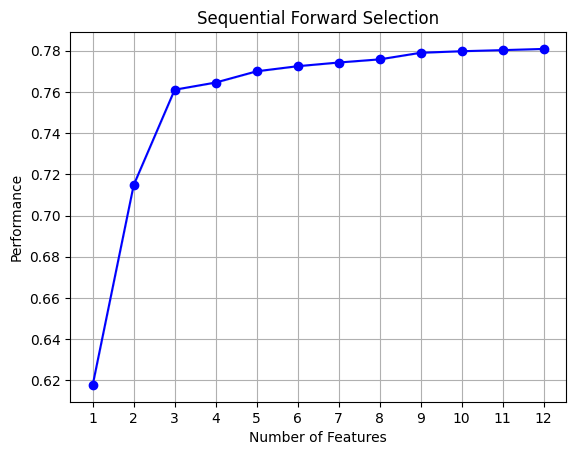

In [ ]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

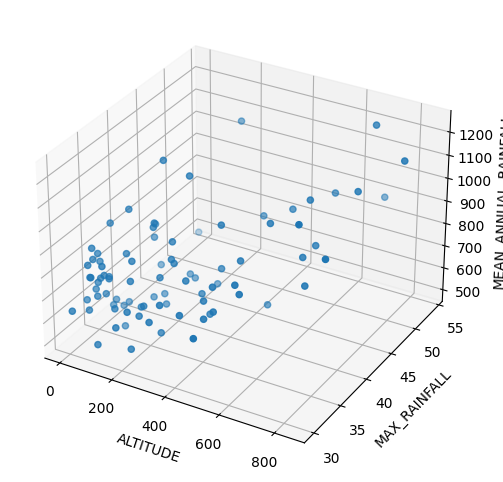

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter3D(
    test_set["ALTITUDE"].values,
    test_set["MAX_RAINFALL"].values,
    test_set["MEAN_ANNUAL_RAINFALL"].values,
)

ax.set_xlabel("ALTITUDE")
ax.set_ylabel("MAX_RAINFALL")
ax.set_zlabel("MEAN_ANNUAL_RAINFALL")
plt.show()

In [ ]:
def remove_feature(ds, current_features, dependent_var, scoring):
    results = {'predictor': [], 'aic': [], 'bic': []}
    for col in current_features:
        # Build our formula string by joining the list current_features and removing one
        remaining_features = current_features.copy()
        remaining_features.remove(col)
        formula = f"{dependent_var} ~ {' + '.join(remaining_features)}"
        model = sm.OLS.from_formula(formula, data=ds).fit()
        results['predictor'].append(col)
        results["aic"].append(model.aic)
        results["bic"].append(model.bic)
    return pd.DataFrame(results).sort_values(by=[scoring], ascending=True)

def backward_selector(ds, dependent_var, scoring):
    # A dict to store the final results
    results = {'predictor': [], 'aic': [], 'bic': []}
    # The same to store the first iteration
    scoring_dict = {'predictor': [], 'aic': [], 'bic': []}
    current_features = ds.columns.drop(dependent_var).tolist()
    formula = f"{dependent_var} ~ {' + '.join(current_features)}"
    model = sm.OLS.from_formula(formula, data=ds).fit()
    # Append the results of the first iteration
    scoring_dict["predictor"].extend(current_features)
    scoring_dict['aic'].extend([model.aic] * len(current_features))
    scoring_dict['bic'].extend([model.bic] * len(current_features))
    # Transform scoring to table
    scoring_table = pd.DataFrame(scoring_dict).sort_values(by=[scoring], ascending=True)
    prev_score = scoring_table[scoring].min()
    while len(current_features) > 1:


        # Remove a feature
        scoring_table = remove_feature(ds, current_features, dependent_var, scoring)
        # Stop if the scoring is worse
        if prev_score < scoring_table[scoring].min():
          break
        # Remove the predictor with the highest score
        current_features.remove(scoring_table.loc[0, 'predictor'])
        formula = f"{dependent_var} ~ {' + '.join(current_features)}"
        prev_score = scoring_table[scoring].min()
        results['predictor'].append(scoring_table.loc[0, 'predictor'])
        results['aic'].append(scoring_table[scoring].min())
        results['bic'].append(scoring_table['bic'].min())
    return pd.DataFrame(results), formula



In [ ]:
# Assuming you have the 'train' DataFrame and the 'MEAN_ANNUAL_RAINFALL' column
results, formula= backward_selector(train_set, 'MEAN_ANNUAL_RAINFALL', 'aic')
print("Final formula: " + formula)
results

Final formula: MEAN_ANNUAL_RAINFALL ~ LON + ALTITUDE + RECORD_LENGTH + MEAN_ANNUAL_AIR_TEMP + MEAN_MONTHLY_MAX_TEMP + MEAN_MONTHLY_MIN_TEMP + MEAN_ANNUAL_WIND_SPEED + MEAN_CLOUD_COVER + MAX_MONTHLY_WIND_SPEED + MAX_AIR_TEMP + MAX_RAINFALL + MIN_AIR_TEMP + MEAN_RANGE_AIR_TEMP


,predictor,aic,bic
0,LAT,4096.984863,4151.03587


In [ ]:
train_set.columns.to_list()

['LAT',
 'LON',
 'ALTITUDE',
 'RECORD_LENGTH',
 'MEAN_ANNUAL_AIR_TEMP',
 'MEAN_MONTHLY_MAX_TEMP',
 'MEAN_MONTHLY_MIN_TEMP',
 'MEAN_ANNUAL_WIND_SPEED',
 'MEAN_CLOUD_COVER',
 'MEAN_ANNUAL_RAINFALL',
 'MAX_MONTHLY_WIND_SPEED',
 'MAX_AIR_TEMP',
 'MAX_RAINFALL',
 'MIN_AIR_TEMP',
 'MEAN_RANGE_AIR_TEMP']

In [ ]:
remove_feature(train_set, ['ALTITUDE', 'MAX_RAINFALL'], 'MEAN_ANNUAL_RAINFALL', 'aic')

,predictor,aic,bic
1,MAX_RAINFALL,4476.290888,4484.012461
0,ALTITUDE,4245.965298,4253.686870


In [ ]:
def model_rmse(model_results):
    return np.sqrt(model_results.mse_resid)

In [ ]:
def diff_rmse(obs, preds):
    return np.sqrt(np.sum((obs-preds)**2)/len(obs))

Simple: Altitude

In [ ]:
simple_alt_model = smf.ols(formula='MEAN_ANNUAL_RAINFALL ~ ALTITUDE', data=train_set)
results = simple_alt_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     MEAN_ANNUAL_RAINFALL   R-squared:                       0.356
Model:                              OLS   Adj. R-squared:                  0.354
Method:                   Least Squares   F-statistic:                     192.8
Date:                  Thu, 17 Oct 2024   Prob (F-statistic):           3.37e-35
Time:                          19:20:37   Log-Likelihood:                -2236.1
No. Observations:                   351   AIC:                             4476.
Df Residuals:                       349   BIC:                             4484.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    629.3677     12.596     49.965      0.000     604.594     654.141
ALTITUDE       0.5019      0.036     13.884      0.000       0.431       0.573
==============================================================================
Omnibus:                       40.716   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.019
Skew:                           0.862   Prob(JB):                     5.06e-12
Kurtosis:                       3.766   Cond. No.                         580.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

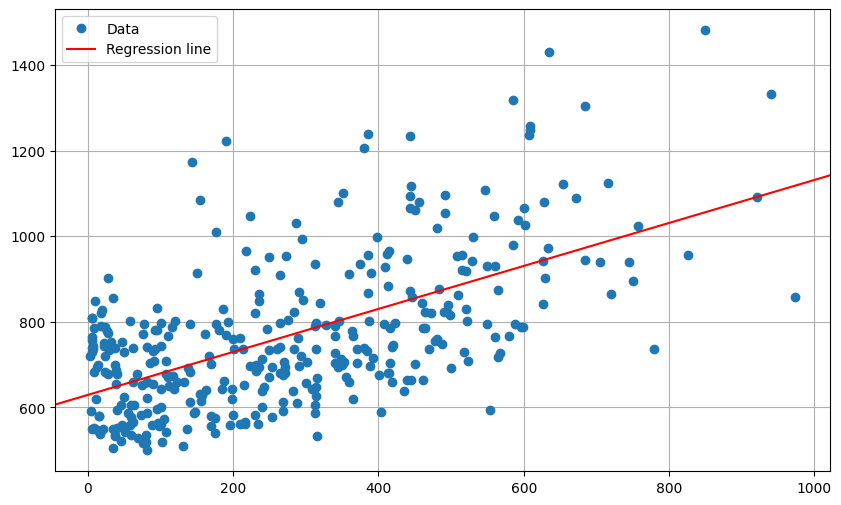

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_set["ALTITUDE"], train_set["MEAN_ANNUAL_RAINFALL"], "o", label="Data")
abline_plot(model_results=results, ax=ax, color="red", label="Regression line")
ax.grid()
ax.legend(loc="best")

In [ ]:
pred = results.predict(test_set)

test_rmse = diff_rmse(test_set["MEAN_ANNUAL_RAINFALL"], pred)
print("RMSE on test set:", test_rmse)
model_outcome = {}
model_outcome["simple_alt"] = {
    "model": simple_alt_model,
    "results": results,
    "rmse": pd.DataFrame.from_dict({"name": pd.Index(["simple alt model"]), "train_RMSE": model_rmse(results), "test_RMSE": test_rmse})
}

RMSE on test set: 143.1685655063734


Simple Max rainFall model

In [ ]:
simple_maxRainFall = smf.ols(formula='MEAN_ANNUAL_RAINFALL ~ MAX_RAINFALL', data=train_set)
results = simple_maxRainFall.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     MEAN_ANNUAL_RAINFALL   R-squared:                       0.666
Model:                              OLS   Adj. R-squared:                  0.665
Method:                   Least Squares   F-statistic:                     695.2
Date:                  Thu, 17 Oct 2024   Prob (F-statistic):           4.60e-85
Time:                          19:20:38   Log-Likelihood:                -2121.0
No. Observations:                   351   AIC:                             4246.
Df Residuals:                       349   BIC:                             4254.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -196.2916     37.019     -5.302      0.000    -269.100    -123.483
MAX_RAINFALL    25.4727      0.966     26.367      0.000      23.573      27.373
==============================================================================
Omnibus:                        0.783   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.676   Jarque-Bera (JB):                0.569
Skew:                           0.073   Prob(JB):                        0.752
Kurtosis:                       3.132   Cond. No.                         260.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

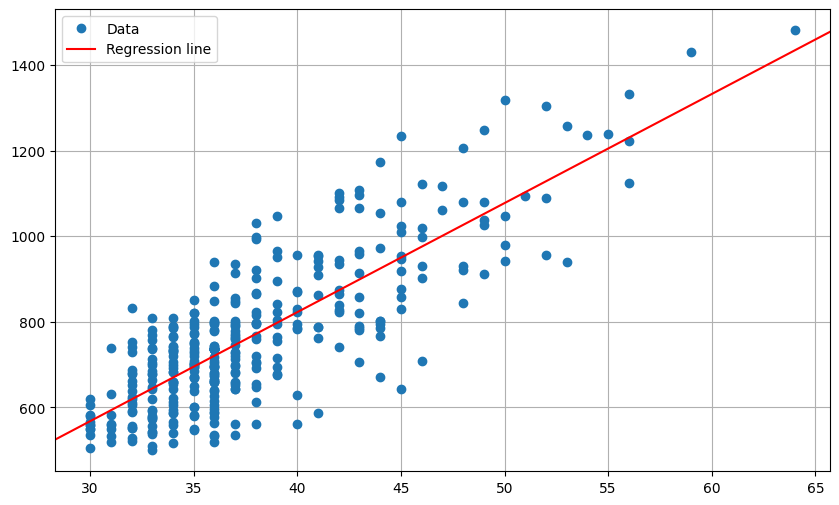

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_set["MAX_RAINFALL"], train_set["MEAN_ANNUAL_RAINFALL"], "o", label="Data")
abline_plot(model_results=results, ax=ax, color="red", label="Regression line")
ax.grid()
ax.legend(loc="best")

In [ ]:
pred = results.predict(test_set)

test_rmse = diff_rmse(test_set["MEAN_ANNUAL_RAINFALL"], pred)
print("RMSE on test set:", test_rmse)
model_outcome["simple_meanAnnTemp"] = {
    "model": simple_maxRainFall,
    "results": results,
    "rmse": pd.DataFrame.from_dict({"name": pd.Index(["simple meanAnnTemp model"]), "train_RMSE": model_rmse(results), "test_RMSE": test_rmse})
}

RMSE on test set: 125.75832810318703


In [ ]:
multi_alt_rain_model = smf.ols(formula='MEAN_ANNUAL_RAINFALL ~ ALTITUDE + MAX_RAINFALL', data=train_set)
results = multi_alt_rain_model.fit()

pred = results.predict(test_set)

test_rmse = diff_rmse(test_set["MEAN_ANNUAL_RAINFALL"], pred)
print("RMSE on test set:", test_rmse)

model_outcome["multi_alt_rain"] = {
    "model": multi_alt_rain_model,
    "results": results,
    "rmse": pd.DataFrame.from_dict({"name": pd.Index(["multi alt rain model"]), "train_RMSE": model_rmse(results), "test_RMSE": test_rmse})
}

RMSE on test set: 124.82153877358358


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     MEAN_ANNUAL_RAINFALL   R-squared:                       0.673
Model:                              OLS   Adj. R-squared:                  0.672
Method:                   Least Squares   F-statistic:                     358.9
Date:                  Thu, 17 Oct 2024   Prob (F-statistic):           2.65e-85
Time:                          19:20:39   Log-Likelihood:                -2116.9
No. Observations:                   351   AIC:                             4240.
Df Residuals:                       348   BIC:                             4251.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -134.7240     42.487     -3.171      0.002    -218.288     -51.160
ALTITUDE         0.0970      0.034      2.863      0.004       0.030       0.164
MAX_RAINFALL    23.1354      1.257     18.400      0.000      20.662      25.608
==============================================================================
Omnibus:                        1.965   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.835
Skew:                           0.176   Prob(JB):                        0.400
Kurtosis:                       3.033   Cond. No.                     2.76e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
rmses = pd.concat([model_outcome["simple_alt"]["rmse"],model_outcome["simple_meanAnnTemp"]["rmse"],model_outcome["multi_alt_rain"]["rmse"]])

In [ ]:
#rmses = pd.concat([rmses, model_outcome["multi_alt_rain"]["rmse"]])
rmses

,name,train_RMSE,test_RMSE
0,simple alt model,141.840524,143.168566
0,simple meanAnnTemp model,102.166540,125.758328
0,multi alt rain model,101.129135,124.821539


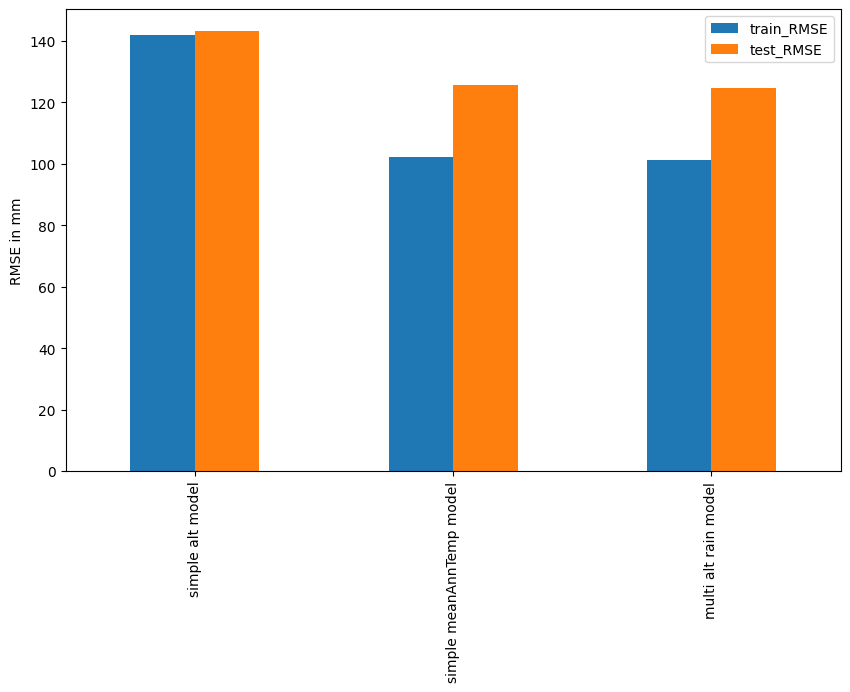

In [ ]:
_, ax = plt.subplots(figsize=(10,6))
rmses.plot(kind="bar", x="name", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE in mm")
plt.show()